*TODO*

*   weird looking boards
*   rnn???? / new way to implement the solver
*   classifier (is the board easy, medium, or hard??) ideas could involve looking at runtime, straight up the content of the board, or outputs of alexei/someone else
*   




In [ ]:
from collections import Counter, defaultdict
from itertools import product
import math
import io
import os
import time
import random
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import statistics

In [ ]:
#PREPROCESSING
def get_ngrams(path, n):
  result = []
  with open(path) as input:
    for line in input:
      if(len(line)<3 or len(line)>16):
        continue
      line = "0" + line
      for i in range(len(line) - (n-1)):
        result.append((line[i:i+n]))
  return result


def post_process(input):
  result = []
  for value in input:
    result.append(value[1:-1])
  return result

In [ ]:
#HELPER FUNCTIONS

#turns a 2d matrix into an adjacency list of indeces
def board_to_adjlist(board):
    result = dict()
    for i in range(len(board)):
        for j in range(len(board[0])):
            idx = (i,j)
            neighbors = []
            for x in range(-1,2):
                for y in range(-1,2):
                    if(not(x == 0 and y ==0)):
                        if(x + i >=0 and y + j >=0 and x + i < len(board) and y + j < len(board[0])):
                            neighbors.append((i+x,j+y))
            result[idx] = neighbors
    return result

#turns a 2d matrix into a list of characters
def board_to_list(board):
  result = []
  for row in board:
    result = result + row
  result.sort()
  return result

def board_to_dict(board):
  result = dict()
  for i in range(len(board)):
    for j in range(len(board[0])):
      if(board[i][j] not in result):
        result[board[i][j]] = [(i,j)]
      else:
        result[board[i][j]].append((i,j))
  return result

def exists(word, chars):
  #REQUIRES: char is sorted
  word = list(word)
  word.sort()
  curr = 0
  i = 0
  length = len(chars)
  goal = len(word)
  while(i < length):
    if(curr == goal):
      return True
    if(word[curr] == chars[i]):
      curr +=1
    elif(word[curr] < chars[i]):
      return False
    i +=1
  return curr == goal 

def validate(dictionary, result):
  res = []
  for word in result:
    if(dictionary.get_word(word)):
      res.append(word)
  return res 

## CODE FOR TESTING ##

# prepares the dict of letters to scrabble freqs that we use in the next function
def generate_scrabble_freqs():
  scrabble_freqs = {
      'e': 12.49,
      't':  9.28,
      'a':  8.04,
      'o':  7.64,
      'i':  7.57,
      'n':  7.23,
      's':  6.51,
      'r':  6.28,
      'h':  5.05,
      'l':  4.07,
      'd':  3.82,
      'c':  3.34,
      'u':  2.73,
      'm':  2.51,
      'f':  2.40,
      'p':  2.14,
      'g':  1.87,
      'w':  1.68,
      'y':  1.66,
      'b':  1.48,
      'v':  1.05,
      'k':  0.54,
      'x':  0.23,
      'j':  0.16,
      'q':  0.12,
      'z':  0.09
  }
  scrabble_freqs = dict(sorted(scrabble_freqs.items(), key=lambda x:x[1]))
  index = -1
  preventry = ""
  for entry in scrabble_freqs:
    scrabble_freqs[entry[0]] = round(scrabble_freqs[entry[0]] * 100)
    # if the previous entry exists, add it to the current entry
    if(index >= 0):
      scrabble_freqs[entry[0]] = scrabble_freqs[entry[0]] + scrabble_freqs[preventry]
    index += 1
    preventry = entry[0]
  return scrabble_freqs

#generates number_of_boards boards with dimensions x by y
def generate_random_boards(number_of_boards, x, y):
  letter_freqs = generate_scrabble_freqs()
  boards = []
  for i in range(number_of_boards):
    boards.append([[0]*y for i in range(x)])
    # fill up the board w/random letters
    for j in range(x):
      for k in range(y):
        # generate random letter
        seed = random.randint(0,9998)
        letter = ''
        for l in letter_freqs:
          if(seed <= letter_freqs[l]):
            letter = l
            break
        assert(letter != '')
        boards[i][j][k] = letter.upper()
  return boards

def precision(sols, ref_sols):
  prec = 0
  if(len(sols) == 0):
    return 0
  for word in sols:
    if(word in ref_sols):
      prec += 1
  return prec/len(sols)

def recall(sols, ref_sols):
  rec = 0
  if(len(ref_sols) == 0):
    return 0
  for word in ref_sols:
    if(word in sols):
      rec += 1
  return rec/len(ref_sols)

In [ ]:
generate_random_boards(2,4,4)

[[['E', 'I', 'E', 'O'],
  ['H', 'T', 'B', 'H'],
  ['O', 'T', 'E', 'A'],
  ['N', 'G', 'T', 'E']],
 [['R', 'L', 'T', 'T'],
  ['E', 'D', 'H', 'I'],
  ['P', 'L', 'C', 'E'],
  ['E', 'M', 'H', 'T']]]

# Building a Literal Hash Dictionary

In [ ]:
class Dictionary():
  def __init__(self, path, size):
    self.size = size
    self.book = self.build(path, size)
    self.listed = self.to_list(path)
  
  def build(self, path, size):
    result = dict()
    with open(path) as input:
      for line in input:
        line = line[:-1]
        num = hash(line) % size
        if num in result:
          result[num].append(line)
        else:
          result[num] = [line]
    return result
  
  def to_list(self, path):
    result = []
    with open(path) as input:
      for line in input:
        result.append(line[:-1])
    return result

  def get_word(self, word):
    num = hash(word) % self.size
    return (num in self.book and word in self.book[num])
  






# Building Our N-Gram Language Model

In [ ]:
class LanguageModel():
    def __init__(self, n, train_data, alpha=1):
        """
        Language model class.
        
        Args
        ____
        n: int
            n-gram order
        train_data: List[List]
            list of words in the dictionary that have not been preprocessed yet
        alpha: float
            Smoothing parameter
        
        Other required parameters:
            self.vocab: vocabulary dict with counts
            self.model: n-gram language model, i.e., n-gram dict with probabilties
            self.n_grams_counts: Frequency count for each of the n-grams present in the training data
            self.prefix_counts: Frequency count of all the corresponding n-1 grams present in the training data
        """
        self.n = n
        self.train_data = train_data
        self.tokens = self.train_data
        self.n_grams_counts = None
        self.prefix_counts = None
        self.vocab  = Counter(self.tokens)
        self.alpha = alpha
        self.model = self.build()

    def get_smooth_probabilities(self,n_gram):
      vocab_size = len(self.vocab)
      ngram_sum = self.n_grams_counts[n_gram]

      prefix_sum = len(self.tokens)
      if(self.n>1):
        prefix_sum = self.prefix_counts[n_gram[0:self.n-1]]
        
        

      return (ngram_sum + self.alpha)/(prefix_sum + self.alpha*vocab_size)


      #Returns the smoothed probability of a single ngram, using Laplace Smoothing. Remember to handle the special case of n=1
      #Use the class variables we defined in the build function. It is suggested to implement the build function before this one.

    
    #TODO:
    def build(self):
        
        #Returns a n-gram (could be a unigram) dict with n-gram tuples as keys and probabilities as values. 
        #It could be a unigram model as well
        ngrams = get_ngrams(self.train_data,n=self.n)
        prefix_ngrams = get_ngrams(self.train_data,n = self.n-1)

        self.n_grams_counts = Counter(ngrams)
        self.prefix_counts = Counter(prefix_ngrams)

        prob = dict()
        for n_gram in self.n_grams_counts:
          prob[n_gram] = self.get_smooth_probabilities(n_gram)

        return prob

# Albert: N-Gram Language Model-Based Solver

In [ ]:
class Albert():
  def __init__(self, model,n):
    # I want to pass in a naive bayes n-gram model here.
    #the probability "p" is the parameter we want to train
    self.model = model
    self.p = 0.03
    self.n = n
    self.weight = 0.5
    self.learning_rate = .05
  
  def check_probability(self, path, next):
    candidate = path[-(self.n-1):] + next
    return (candidate in self.model and self.model[candidate] >= self.p)
  

  def bfs(self, tile, adjlist, board, path, result, visited):
    #INPUT
    #tile : the root tile that we are starting from
    #adjlist : adjacency list of our graph
    #board : 2d matrix of our graph so accessing is easier
    #path : the current accumulated letters for our words
    #pathprob : should we add the log probability of the current path? will do it on second try
    #result : the resulting set from the past
    #visited : the tiles that we have already visited

    #OUTPUT
    #result : the resulting set after conducting bfs

    #check if current path is a word
    if(len(path)>3 and self.check_probability(path, "\n")):
      result.add(path + "\n")

    #check if extensions are a word
    #for each neighbor
    for neighbor in adjlist[tile]:
        #if we haven't visited it yet, we do smth
        #so if we've visited all the neighbors we just move on
        if neighbor not in visited:
            next = str(board[neighbor[0]][neighbor[1]])
            #check probabilities
            if(self.check_probability(path, next)):
              new = path + next
              temp = visited.copy()
              temp.append(neighbor)
              result = result | self.bfs(neighbor, adjlist, board, new, result, temp)
    return result 


  def solve(self, board):
      #INPUT
      # board: a 2-d char array of n x n dimensions
      # cutoff: the probability 0 < cutoff < 1, such that if the probability a character follows is lower than this cutoff we do not pursue this path

      #OUTPUT
      # result: a set of words found from the board

      result = set()

      #first, we want to make an adjacency list
      adjlist = board_to_adjlist(board)
      for tile in adjlist:
        visited = [tile]
        path = "0" + str(board[tile[0]][tile[1]])
        found = self.bfs(tile, adjlist, board,path , set(), visited)
        result = result | found
         
      return post_process(result)
  

  
  def train(self, boards, ref_sol):
    board_num = 0
    index_coords = []
    precision_coords = []
    recall_coords = []
    p_coords = []
    runtime_coords = []
    for board in boards:
      # print("Board number ", board_num)
      # print(board)
      # this timer will make sure that every board takes less than some amount of time
      board = [board]
      starttime = time.perf_counter()
      metrics = self.evaluate(board, ref_sol)
      endtime = time.perf_counter()
      runtime = endtime - starttime
      # print("Time taken: ", runtime)
      # bullshit weights tbh but here is where we will evaluate and update
      # if recall isn't high enough, then subtract something from the cutoff prob
      self.p = self.p - (self.weight)*(1-metrics[0][1])*self.learning_rate
      # if time is too high, add something to the cutoff prob (assumption is a tradeoff b/t time and recall)
      self.p = self.p + self.learning_rate*runtime
      # print("New cutoff: ", self.p, "\n")
      # append a ton of stuff to a ton of lists for plotting purposes
      index_coords.append(board_num)
      precision_coords.append(metrics[0][0])
      recall_coords.append(metrics[0][1])
      p_coords.append(self.p)
      runtime_coords.append(runtime)
      # increment board number
      board_num += 1
    # now we are going to plot a bunch of stuff for eval purposes
    plt.plot(index_coords, precision_coords)
    plt.ylabel("precision")
    plt.show()
    plt.plot(index_coords, recall_coords)
    plt.ylabel("recall")
    plt.show()
    plt.plot(index_coords, p_coords)
    plt.ylabel("p values")
    plt.show()
    plt.plot(index_coords, runtime_coords)
    plt.ylabel("runtime")
    plt.show()



    #essentially, what we want to do here is solve each board
    #its better to make our probability initially really small so that
    #runtime isn't dogshit (it will take eons to run if we go through every single possible path)
    #then our loss function will be p = p * log (wP/wR) (thinking about adding here, see which one does better), 
    # where wP is the weighted precision and wR is the weighted recall (this is based on wordhunt scores, eg 800 for 5 letter words)
    #we keep going until we go through all the boards and solutions
    #afterwards, print our final p-value to see where it ended up
    return
  

  def evaluate(self, boards, ref_sol):
    # boards: a list of boards (generated by the helper function generate_random_boards)
    # this will contain a a row for every board; each row contains the precision, recall, and f1 of our solution against reference, in that order
    summary_stats = []
    epoch = 0
    for board in boards:
      reference = ref_sol.solve(board)
      train_sol = self.solve(board)
      # find precision, recall
      prec = precision(train_sol, reference)
      rec = recall(train_sol, reference)
      f1 = 0
      if(prec + rec != 0):
        f1 = (prec * rec)/(prec + rec)
      # print("Precision: ", prec, "Recall: ", rec, "F1", f1, "Cutoff prob: ", self.p)
      summary_stats.append([prec, rec, f1])
    return summary_stats

Possible Cross-Entropy Loss Function:

Loss = -1/(output size) * Σ_(from 1 ~ output size) (x_i * log xhat_i) + ((1-x_i) * log (1-xhat_i))

ideally if we wanna take time into account, we should add a penalty term to Loss Function that is proportional to Time Elapsed (e.g. maybe log?? MSE), where it is MSE between predicted (based on ngram length?) - true elapsed time

# Alexei: Albert 2.0
Alexei is also a n-gram based, model, but this time we will look at overall path probability, rather than localized n-gram probability.

In [ ]:
class Alexei():
  def __init__(self, path , n, size, beta, alpha):
    # I want to pass in a naive bayes n-gram model here.
    #the probability "p" is the parameter we want to train
    lm = LanguageModel(n, path)
    dictionary = Dictionary(path, size)
    self.model = lm.model
    self.beta = beta
    self.alpha = alpha
    self.p = self.find_cutoffs(dictionary.listed)
    self.p[16] = -30
    self.n = n
    
  
  def calculate_logprob(self, word, n):
    word = "0" + word + "\n"
    result = 0
    for i in range(len(word) - (n-1)):
      result += math.log(self.model[word[i:i+n]])
    return result
  
  def eq(self, x, alpha, beta):
    exponent = -((1/math.log(x))*(x-10))
    coefficient = (0.5 - 1/(1 + math.exp(exponent)))
    return beta + alpha*coefficient
  
  def find_cutoffs(self, dictionary):
    temp = dict()
    result = dict()
    for word in dictionary:
      if (len(word) in temp):
        temp[len(word)].append(self.calculate_logprob(word, 3))
      else:
        temp[len(word)] = [self.calculate_logprob(word, 3)]
    for length,probabilities in temp.items():
        result[length] = statistics.mean(probabilities) - (self.eq(length, self.alpha, self.beta))*statistics.stdev(probabilities)
        #print("length: {}, mean: {:.3f}, std: {:.3f}".format(length, statistics.mean(probabilities), statistics.stdev(probabilities)))
    return result
  
  def check_probability(self, path, pathprob, next):
    length = len(path)
    #if(length == 16):
    #  print(path)
    candidate = path[-(self.n-1):] + next
    
    if (candidate in self.model):
      nextprob = math.log(self.model[candidate])
      if (length == 2 or pathprob + nextprob >= self.p[length-1]):
        return nextprob
    return 0
  

  def bfs(self, tile, adjlist, board, path, pathprob, result, visited):
    #INPUT
    #tile : the root tile that we are starting from
    #adjlist : adjacency list of our graph
    #board : 2d matrix of our graph so accessing is easier
    #path : the current accumulated letters for our words
    #pathprob : should we add the log probability of the current path? will do it on second try
    #result : the resulting set from the past
    #visited : the tiles that we have already visited

    #OUTPUT
    #result : the resulting set after conducting bfs

    #check if current path is a word
    if(len(path)>3 and self.check_probability(path, pathprob,"\n")):
      result.add(path + "\n")

    #check if extensions are a word
    #for each neighbor
    for neighbor in adjlist[tile]:
        #if we haven't visited it yet, we do smth
        #so if we've visited all the neighbors we just move on
        if neighbor not in visited:
            next = str(board[neighbor[0]][neighbor[1]])
            #check probabilities
            nextprob = self.check_probability(path, pathprob, next)
            if(nextprob):
              new = path + next
              temp = visited.copy()
              temp.append(neighbor)
              result = result | self.bfs(neighbor, adjlist, board, new, pathprob + nextprob, result, temp)
    return result 


  def solve(self, board):
      #INPUT
      # board: a 2-d char array of n x n dimensions
      # cutoff: the probability 0 < cutoff < 1, such that if the probability a character follows is lower than this cutoff we do not pursue this path

      #OUTPUT
      # result: a set of words found from the board

      result = set()

      #first, we want to make an adjacency list
      adjlist = board_to_adjlist(board)
      for tile in adjlist:
        visited = [tile]
        path = "0" + str(board[tile[0]][tile[1]])
        found = self.bfs(tile, adjlist, board, path , 0, set(), visited)
        result = result | found
         
      return post_process(result)
  
  def train(self, boards, solutions):
    #essentially, what we want to do here is solve each board
    #its better to make our probability initially really small so that
    #runtime isn't dogshit (it will take eons to run if we go through every single possible path)
    #then our loss function will be p = p * log (wP/wR) (thinking about adding here, see which one does better), 
    # where wP is the weighted precision and wR is the weighted recall (this is based on wordhunt scores, eg 800 for 5 letter words)
    #we keep going until we go through all the boards and solutions
    #afterwards, print our final p-value to see where it ended up
    for board in boards:
      candidate_sol = self.solve(board)
      prec = self.precision()
    return
  

  def evaluate(self, boards):
    # boards: a list of boards (generated by the helper function generate_random_boards)
    # this will contain a a row for every board; each row contains the precision, recall, and f1 of our solution against reference, in that order
    summary_stats = []
    epoch = 0
    for board in boards:
      print(board)
      print("epoch", epoch, ":\n")
      # TODO: FIX THE SYNTAX (ref_sol.solve is 100% not correct)
      ref_sol = ref_sol.solve(board)
      train_sol = self.solve(board)
      # find precision, recall
      prec = self.precision(train_sol, ref_sol)
      rec = self.recall(train_sol, ref_sol)
      f1 = (prec * rec)/(prec + rec)
      print("Precision: ", prec, "Recall: ", rec, "F1", f1)
      summary_stats.append([prec, rec, f1])
    return summary_stats

# Isaac: Dictionary-Based Solver

In [ ]:
class Isaac():
  def __init__(self, dictionary):
    self.dictionary = dictionary.listed
  

  def dfs(self, word, tile, adjlist, visited, path, board):
    if(path == len(word)):
      return True
    
    for neighbor in adjlist[tile]:
      if neighbor not in visited:
        if board[neighbor[0]][neighbor[1]] == word[path]:
          temp = visited.copy()
          temp.append(neighbor)
          if(self.dfs(word,neighbor, adjlist, temp, path + 1, board)):
            return True

    return False



  def solve(self, board):
    result = []
    adjlist = board_to_adjlist(board)
    lst = board_to_list(board)
    ref = board_to_dict(board)
    #im going to make a dictionary for easy access

    for word in self.dictionary:
      if len(word) > 2 and len(word) <= 16 and exists(word, lst):
        for start in ref[word[0]]:
          if(self.dfs(word, start, adjlist, [start], 1, board)):
            result.append(word)
            break
    return result


# Testing Begins!

In [ ]:

tester = [['A','N','T','E'], ['E','T','A','A'], ['R','D','N','N'], ['L','L','E','K']]

In [ ]:
dictionary = Dictionary("dictionary.txt",10000)

In [ ]:
lm = LanguageModel(3, "dictionary.txt")
albert = Albert(lm.model, 3)

In [ ]:
tic = time.perf_counter()
result = albert.solve(tester)
result = sorted(result, key = len, reverse = True)
print(len(result))
result = validate(dictionary, result)
toc = time.perf_counter()
print(toc - tic)
result = sorted(result, key = len, reverse = True)
print(result)
print(len(result))

8606
0.8046062280000115
['ANDANTE', 'TANNATE', 'DENTATE', 'ENTENTE', 'TANNED', 'LENDER', 'LENTEN', 'NATTER', 'NATANT', 'REATA', 'ANTED', 'TATER', 'EATER', 'ENDER', 'DATER', 'ENATE', 'ENTER', 'EATEN', 'ANTRE', 'KENTE', 'RENTE', 'RENT', 'DEAN', 'DELL', 'TENT', 'REDE', 'LENT', 'KENT', 'DATA', 'TATE', 'ANTE', 'ANTA', 'DATE', 'DENT', 'ANNA', 'LEND', 'NANA', 'NAN', 'ANE', 'ELL', 'KEN', 'TED', 'DAN', 'RET', 'ETA', 'TEN', 'ANT', 'AND', 'LED', 'ANA', 'DEL', 'DEN', 'ATE', 'TAN', 'RED', 'NET', 'END']
57


In [ ]:
alexei = Alexei("dictionary.txt", 3,10000, 0.3, 0.3)

In [ ]:
tic = time.perf_counter()
result = alexei.solve(tester)
result = sorted(result, key = len, reverse = True)
print(len(result))
result = validate(dictionary, result)
toc = time.perf_counter()
print(toc - tic)
result = sorted(result, key = len, reverse = True)
print(result)
print(len(result))

3290
0.22196086899930378
['ANTEATER', 'ANTEDATE', 'ANDANTE', 'TANNATE', 'DENTATE', 'ENTENTE', 'REDATE', 'LENDER', 'LENTEN', 'TANKED', 'TANNED', 'NATTER', 'NATANT', 'TEATED', 'ENTER', 'REATA', 'ELDER', 'ANTED', 'TATER', 'EATEN', 'ANTRE', 'EATER', 'ENDER', 'KNELL', 'DATER', 'ANENT', 'KENTE', 'ENATE', 'RENTE', 'REDAN', 'ANTAE', 'RENT', 'DEAN', 'KENT', 'TATE', 'ANTE', 'ANTA', 'DATE', 'NERD', 'DELL', 'DANK', 'DENT', 'TANK', 'ANNA', 'TENT', 'REDE', 'LEND', 'LENT', 'NAN', 'TAT', 'ANE', 'ELL', 'KEN', 'NAE', 'TED', 'DAN', 'DEN', 'RET', 'ETA', 'ATE', 'TEN', 'ELD', 'TAD', 'TAN', 'ANT', 'EAT', 'AND', 'LED', 'ANA', 'RED', 'NET', 'END', 'DEL']
73


In [ ]:
isaac = Isaac(dictionary)

In [ ]:
boards = generate_random_boards(500, 4,4)
#print(boards)
#albert.train(boards, isaac)
# print(albert.p)

In [ ]:
tic = time.perf_counter()
result = isaac.solve(tester)
result = sorted(result, key = len, reverse = True)
print(len(result))
result = validate(dictionary, result)
toc = time.perf_counter()
print(toc - tic)
result = sorted(result, key = len, reverse = True)
print(result)
print(len(result))

87
0.4502996749997692
['ANTEATER', 'ANTEDATE', 'EDENTATE', 'ANDANTE', 'DENTATE', 'ENTENTE', 'TANNATE', 'ADNATE', 'ANANKE', 'LENDER', 'LENTEN', 'NATANT', 'NATTER', 'REDATE', 'TANKED', 'TANNED', 'TEATED', 'ANENT', 'ANTAE', 'ANTED', 'ANTRE', 'DATER', 'EATEN', 'EATER', 'ELDER', 'ENATE', 'ENDER', 'ENTER', 'KENTE', 'KNELL', 'REATA', 'REDAN', 'RENTE', 'TATER', 'ANNA', 'ANTA', 'ANTE', 'DANK', 'DATA', 'DATE', 'DEAN', 'DELL', 'DENT', 'ETNA', 'KENT', 'LEND', 'LENT', 'NAAN', 'NANA', 'NEAT', 'NERD', 'NETT', 'REDE', 'RENT', 'TANK', 'TATE', 'TEAT', 'TENT', 'ANA', 'AND', 'ANE', 'ANT', 'ATE', 'ATT', 'DAN', 'DEL', 'DEN', 'EAT', 'ELD', 'ELL', 'END', 'ETA', 'KEN', 'LED', 'LEK', 'NAE', 'NAN', 'NET', 'RED', 'RET', 'TAD', 'TAE', 'TAN', 'TAT', 'TEA', 'TED', 'TEN']
87


# MASS TESTING
The idea here is we're going to generate a bunch of random boards and solve each one. We will first evaluate on a few easy metrics that we have already looked at previously


1.   Number Correct/Number Total
2.   Number Correct/Number Generated
3.   Time to Generate



In [ ]:
def get_score(wordlist):
  score = 0
  for word in wordlist:
    length = len(word)
    if (length == 3):
      score += 100
    elif (length == 4):
      score += 400
    elif (length == 5):
      score += 800
    elif (length == 6):
      score += 1400
    else:
      score += 1400 + 400*(length - 6) 
  return score

In [ ]:
def words_per_length(saved, input):
  for item in input:
    saved[len(item)] +=1 
  return saved

In [ ]:
def test(batch, n):
  #summary statistics of albert
  albert_precision = 0
  albert_acc = 0
  albert_time = 0
  albert_score = 0
  #summary statistics of alexei
  alexei_precision = 0
  alexei_acc = 0
  alexei_time = 0
  alexei_score = 0
  #summary statistics of isaac
  isaac_precision = 1
  isaac_acc = 1
  isaac_time = 0 
  isaac_score = 0
  generated = defaultdict(lambda: 0)
  for board in batch:
    
    #TESTING FOR ISAAC - OUR CONTROL SOLUTION
    tic = time.perf_counter()
    isaac_res = isaac.solve(board)
    toc = time.perf_counter()
    isaac_time += (toc - tic)
    isaac_score += get_score(isaac_res)
    refsol = len(isaac_res)

    
    #TESTING FOR ALBERT - OUR FIRST VERSION
    tic = time.perf_counter()
    albert_res = albert.solve(board)
    tot_albert = len(albert_res)
    albert_res = validate(dictionary, albert_res)
    red_albert = len(albert_res)
    toc = time.perf_counter()
    albert_time += (toc - tic)
    albert_precision += red_albert/tot_albert
    albert_acc += red_albert/refsol
    albert_score += get_score(albert_res)
    

    #TESTING FOR ALEXEI - OUR SECOND VERSION
    tic = time.perf_counter()
    alexei_res = alexei.solve(board)
    tot_alexei = len(alexei_res)
    #print(tot_alexei)
    generated = words_per_length(generated, alexei_res)
    alexei_res = validate(dictionary, alexei_res)
    red_alexei = len(alexei_res)
    toc = time.perf_counter()
    alexei_time += (toc - tic)
    alexei_precision += red_alexei/tot_alexei
    alexei_acc += red_alexei/refsol
    alexei_score += get_score(alexei_res)
  
  #printing the final statistics
  print("FINAL SUMMARY STATISTICS")
  print("########################")
  print("ISAAC REFERENCE STATISTICS")
  print("ISAAC NUMBER CORRECT/NUMBER TOTAL: {}".format(isaac_precision))
  print("ISAAC NUMBER CORRECT/NUMBER GENERATED: {}".format(isaac_acc))
  print("ISAAC AVERAGE SCORE: {}".format(isaac_score/n))
  print("ISAAC AVERAGE TIME TO SOLVE: {}".format(isaac_time/n))
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  print("ALBERT REFERENCE STATISTICS")
  print("ALBERT NUMBER CORRECT/NUMBER TOTAL: {}".format(albert_precision/n))
  print("ALBERT NUMBER CORRECT/NUMBER GENERATED: {}".format(albert_acc/n))
  print("ALBERT AVERAGE SCORE: {}".format(albert_score/n))
  print("ALBERT AVERAGE TIME TO SOLVE: {}".format(albert_time/n))
  print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
  
  print("ALEXEI REFERENCE STATISTICS")
  print("ALEXEI NUMBER CORRECT/NUMBER TOTAL: {}".format(alexei_precision/n))
  print("ALEXEI NUMBER CORRECT/NUMBER GENERATED: {}".format(alexei_acc/n))
  print("ALEXEI AVERAGE SCORE: {}".format(alexei_score/n))
  print("ALEXEI AVERAGE TIME TO SOLVE: {}".format(alexei_time/n))






In [ ]:
alexei_stats_rt = dict()
alexei_stats_rc = dict()
batch = generate_random_boards(500,4,4)
alexei = Alexei("dictionary.txt", 3,10000,0,2.5)

test(batch, 500)

FINAL SUMMARY STATISTICS
########################
ISAAC REFERENCE STATISTICS
ISAAC NUMBER CORRECT/NUMBER TOTAL: 1
ISAAC NUMBER CORRECT/NUMBER GENERATED: 1
ISAAC AVERAGE SCORE: 58540.4
ISAAC AVERAGE TIME TO SOLVE: 0.39300642685399273
~~~~~~~~~~~~~~~~~~~~~~~~~~~
ALBERT REFERENCE STATISTICS
ALBERT NUMBER CORRECT/NUMBER TOTAL: 0.06457007462791858
ALBERT NUMBER CORRECT/NUMBER GENERATED: 0.4600438647501498
ALBERT AVERAGE SCORE: 28470.0
ALBERT AVERAGE TIME TO SOLVE: 0.14499557370596175
~~~~~~~~~~~~~~~~~~~~~~~~~~~
ALEXEI REFERENCE STATISTICS
ALEXEI NUMBER CORRECT/NUMBER TOTAL: 0.05925576608238614
ALEXEI NUMBER CORRECT/NUMBER GENERATED: 0.8992711506589818
ALEXEI AVERAGE SCORE: 51621.4
ALEXEI AVERAGE TIME TO SOLVE: 0.1336811253220094


In [ ]:
def distribution_test(n):
  isaacdist = defaultdict(lambda: 0)
  albertdist = defaultdict(lambda: 0)
  alexeidist = defaultdict(lambda: 0)
  total = 0

  batch = generate_random_boards(n,4,4)
  for board in batch:
    refsol = isaac.solve(board)
    albertsol = albert.solve(board)
    albertsol = validate(dictionary, albertsol)
    alexeisol = alexei.solve(board)
    alexeisol = validate(dictionary, alexeisol)
    #getting distribution for the solutions
    for i in range(len(refsol)):
      isaacdist[len(refsol[i])] += 1
      total += 1
    #getting distributions for albert
    for i in range(len(albertsol)):
      albertdist[len(albertsol[i])] += 1
    #getting distributions for alexei    
    for i in range(len(alexeisol)):
      alexeidist[len(alexeisol[i])] += 1
  
  print("DISTRIBUTION STATISTICS")
  print("#######################")
  for length, found in isaacdist.items():
    albertpercent = albertdist[length]/found
    alexeipercent = alexeidist[length]/found
    totaldist = found/total
    print("OF LENGTH {}: ALBERT - {}%\tALEXEI - {}%\tTOTAL DISTRIBUTION -  {}%".format(length, albertpercent, alexeipercent, totaldist))


In [ ]:
distribution_test(500)

DISTRIBUTION STATISTICS
#######################
OF LENGTH 3: ALBERT - 0.4496613535672455%	ALEXEI - 0.8932117940622295%	TOTAL DISTRIBUTION -  0.32927544980465145%
OF LENGTH 4: ALBERT - 0.4875052352366327%	ALEXEI - 0.8652333752152264%	TOTAL DISTRIBUTION -  0.3603299964786961%
OF LENGTH 5: ALBERT - 0.5096955264500765%	ALEXEI - 0.8522707943527811%	TOTAL DISTRIBUTION -  0.1971594815299227%
OF LENGTH 6: ALBERT - 0.4896341463414634%	ALEXEI - 0.8443089430894309%	TOTAL DISTRIBUTION -  0.08249911967402787%
OF LENGTH 7: ALBERT - 0.460231135282121%	ALEXEI - 0.8477226376614548%	TOTAL DISTRIBUTION -  0.02466589533343394%
OF LENGTH 8: ALBERT - 0.43670886075949367%	ALEXEI - 0.810126582278481%	TOTAL DISTRIBUTION -  0.0052987239465432535%
OF LENGTH 10: ALBERT - 0.6666666666666666%	ALEXEI - 0.6666666666666666%	TOTAL DISTRIBUTION -  0.00010060868252930228%
OF LENGTH 9: ALBERT - 0.35%	ALEXEI - 0.775%	TOTAL DISTRIBUTION -  0.0006707245501953485%


# Exploring Distributions

I explore the relationship between probability and word length here.

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
#idk what this is but im gonna try it
def calculate_logprob(word, n):
  word = "0" + word + "\n"
  result = 0
  for i in range(len(word) - (n-1)):
    if(word[i:i+n] in lm.model):
      result += math.log(lm.model[word[i:i+n]])
  return result

temp = defaultdict(lambda: list())
result = dict()
for word in dictionary.listed:
  if (len(word) > 4):
    temp[len(word)].append(calculate_logprob(word[:5], 3))

for length,probabilities in temp.items():
    result[length] = sum(probabilities)/len(probabilities)
baseline = result[5]
for length, probabilities in temp.items():
    data = np.array(probabilities)
    normalized = (np.average(probabilities) - baseline)/(np.std(probabilities))
    print(normalized)
    result[length] = normalized
    
print(result)



  


-1.9076665321879158e-14
-0.4070092510348233
-0.40128288293674175
-0.28599092893476197
-0.19768034901877352
-0.5737234292063061
-0.14560630539897973
-0.03961992469762816
-0.005064031017177949
0.02230557732163934
0.05786176244881148
{5: -1.9076665321879158e-14, 6: -0.4070092510348233, 8: -0.40128288293674175, 9: -0.28599092893476197, 10: -0.19768034901877352, 7: -0.5737234292063061, 11: -0.14560630539897973, 12: -0.03961992469762816, 13: -0.005064031017177949, 14: 0.02230557732163934, 15: 0.05786176244881148}


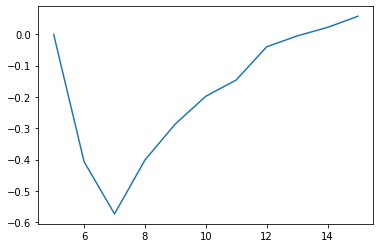

In [ ]:


lists = sorted(result.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()